In [ ]:

import pyspark
from pyspark.sql import SparkSession

# Creación de la sesión de Spark
spark = SparkSession.builder \
    .appName("PRUEBA TECNICA") \
    .getOrCreate()



CARGA DE LOS CSV

In [ ]:
from google.colab import files

# Subir los archivos CSV
uploaded = files.upload()


Saving merchant_categories.csv to merchant_categories.csv
Saving customer_demographics.csv to customer_demographics.csv
Saving customer_accounts.csv to customer_accounts.csv
Saving credit_transactions.csv to credit_transactions.csv


In [ ]:
# Cargar los datos en DataFrames de PySpark
transactions_df = spark.read.option("header", "true").csv("credit_transactions.csv")
accounts_df = spark.read.option("header", "true").csv("customer_accounts.csv")
demographics_df = spark.read.option("header", "true").csv("customer_demographics.csv")
merchant_categories_df = spark.read.option("header", "true").csv("merchant_categories.csv")

# Verificar los primeros registros
transactions_df.show(5)
accounts_df.show(5)
demographics_df.show(5)
merchant_categories_df.show(5)


+--------------+-----------+----------------+-------+------------+---------+-----------------+
|transaction_id|customer_id|transaction_date| amount|        type|   status|merchant_category|
+--------------+-----------+----------------+-------+------------+---------+-----------------+
|         T1001|      C5678|      2023-01-05| 120.50|    purchase|completed|           retail|
|         T1002|      C8925|      2023-01-05|1500.00|cash_advance|completed|              atm|
|         T1003|      C5678|      2023-01-06|  45.20|    purchase|completed|       restaurant|
|         T1004|      C1234|      2023-01-06| 800.00|    purchase|completed|      electronics|
|         T1005|      C7890|      2023-01-07|  60.75|    purchase| declined|           online|
+--------------+-----------+----------------+-------+------------+---------+-----------------+
only showing top 5 rows

+-----------+------------+-----------------+------------+------+-----------------+-----------+---------+
|customer_id|cr

CAPA BRONCE

In [ ]:
# Guardar los DataFrames en formato Parquet (o cualquier otro formato que prefieras)
transactions_df.write.parquet("transactions_bronze.parquet")
accounts_df.write.parquet("accounts_bronze.parquet")
demographics_df.write.parquet("demographics_bronze.parquet")
merchant_categories_df.write.parquet("merchant_categories_bronze.parquet")


CAPA SILVER

In [ ]:
# 1. Cargar los datos desde la Capa Bronze (archivos Parquet)
transactions_bronze_df = spark.read.parquet("transactions_bronze.parquet")
accounts_bronze_df = spark.read.parquet("accounts_bronze.parquet")

# 2. Transformaciones para la Capa Silver

# - Conversión de tipos de datos
transactions_silver_df = transactions_bronze_df.withColumn("amount", transactions_bronze_df["amount"].cast("float"))
accounts_silver_df = accounts_bronze_df.withColumn("credit_limit", accounts_bronze_df["credit_limit"].cast("float"))

# - Eliminar valores nulos en columnas clave
transactions_silver_df = transactions_silver_df.dropna(subset=["customer_id", "transaction_id"])
accounts_silver_df = accounts_silver_df.dropna(subset=["customer_id"])

# - Eliminar duplicados
transactions_silver_df = transactions_silver_df.dropDuplicates()
accounts_silver_df = accounts_silver_df.dropDuplicates()

# ✅ Validación de integridad: Mantener solo transacciones válidas
transactions_silver_df = transactions_silver_df.join(accounts_silver_df, "customer_id", "inner")
transactions_silver_df.show(5)




+-----------+--------------+----------------+------+--------+---------+-----------------+------------+-----------------+------------+------+-----------------+-----------+---------+
|customer_id|transaction_id|transaction_date|amount|    type|   status|merchant_category|credit_limit|account_open_date|credit_score|income|last_payment_date|min_payment|total_due|
+-----------+--------------+----------------+------+--------+---------+-----------------+------------+-----------------+------------+------+-----------------+-----------+---------+
|      C7890|         T1017|      2023-01-30| 80.25|purchase|completed|           retail|      3000.0|       2021-02-18|         650| 45000|       2023-01-25|     100.00|  2000.00|
|      C7890|         T1009|      2023-01-15| 125.3|purchase|completed|       restaurant|      3000.0|       2021-02-18|         650| 45000|       2023-01-25|     100.00|  2000.00|
|      C1234|         T1020|      2023-02-03| 300.0|purchase|completed|           retail|      

In [ ]:
# 3. Guardar los datos transformados en la Capa Silver
transactions_silver_df.write.parquet("transactions_silver.parquet")
accounts_silver_df.write.parquet("accounts_silver.parquet")

# Mostrar los primeros registros de los DataFrames transformados para verificar
transactions_silver_df.show(5)
accounts_silver_df.show(5)

+-----------+--------------+----------------+------+--------+---------+-----------------+------------+-----------------+------------+------+-----------------+-----------+---------+
|customer_id|transaction_id|transaction_date|amount|    type|   status|merchant_category|credit_limit|account_open_date|credit_score|income|last_payment_date|min_payment|total_due|
+-----------+--------------+----------------+------+--------+---------+-----------------+------------+-----------------+------------+------+-----------------+-----------+---------+
|      C7890|         T1017|      2023-01-30| 80.25|purchase|completed|           retail|      3000.0|       2021-02-18|         650| 45000|       2023-01-25|     100.00|  2000.00|
|      C7890|         T1009|      2023-01-15| 125.3|purchase|completed|       restaurant|      3000.0|       2021-02-18|         650| 45000|       2023-01-25|     100.00|  2000.00|
|      C1234|         T1020|      2023-02-03| 300.0|purchase|completed|           retail|      

CAPA GOLD

In [61]:
# Cargar los datos transformados de la Capa Silver
transactions_silver_df = spark.read.parquet("transactions_silver.parquet")
accounts_silver_df = spark.read.parquet("accounts_silver.parquet")

# Agreagación
customer_spending = transactions_silver_df.groupBy("customer_id").sum("amount").withColumnRenamed("sum(amount)", "total_spent")

# Mostrar resultados
customer_spending.show(5)

#Guarda en la ultima capa

customer_spending.write.parquet("customer_spending_dold.parquet")


+-----------+------------------+
|customer_id|       total_spent|
+-----------+------------------+
|      C5678|1541.2999992370605|
|      C7890| 716.3000030517578|
|      C1234| 3175.900001525879|
|      C8925|            4075.0|
|      C9876|            1800.0|
+-----------+------------------+



LLAMADA DE LA ULTIMA CAPA

In [62]:
customer_spending_pd = spark.read.parquet("customer_spending_dold.parquet")


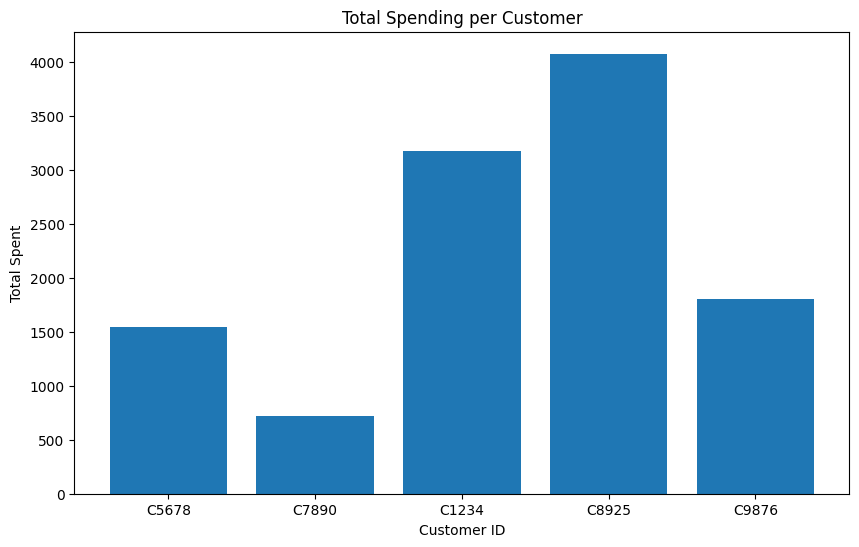

In [63]:
import matplotlib.pyplot as plt

# Convertir el DataFrame a Pandas para facilitar la visualización
customer_spending_pd = customer_spending.toPandas()

# Crear un gráfico de barras del gasto total por cliente
plt.figure(figsize=(10,6))
plt.bar(customer_spending_pd["customer_id"], customer_spending_pd["total_spent"])
plt.xlabel("Customer ID")
plt.ylabel("Total Spent")
plt.title("Total Spending per Customer")
plt.show()
